# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Change working directory.

import os
os.chdir('N:/DevMOOC/UdacityMLnd/P2Intervention/student_intervention/student_intervention')
print os.getcwd()

N:\DevMOOC\UdacityMLnd\P2Intervention\student_intervention\student_intervention


In [2]:
# Import libraries.

import numpy as np
import pandas as pd
import time
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import metrics
from sklearn import grid_search
import pylab as pl
%matplotlib inline

In [3]:
# Read student data.

student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

# Note: The last column 'passed' is the target/label, all other are feature columns.

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [4]:
# TODO: Compute desired values. Replace each '?' with an appropriate expression/function call.

n_students = np.shape(student_data)[0]
n_features = np.shape(student_data)[1]-1
n_passed = len(student_data[student_data.passed=="yes"])
n_failed = len(student_data[student_data.passed=="no"])
grad_rate = 100.*n_passed/n_students

print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [5]:
# Extract feature (X) and target (y) columns.

feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns.

def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [7]:
# First, decide how many training vs test samples you want.

num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets.
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset.

import random
samp = random.sample(X_all.index, 300)
X_train = X_all.ix[samp]
y_train = y_all.ix[samp]
X_test = X_all.drop(samp)
y_test = y_all.drop(samp)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])

# Note: If you need a validation set, extract it from within training data.

Training set: 300 samples
Test set: 95 samples


4. Training and Evaluating Models
---------

Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

* What are the general applications of this model? What are its strengths and weaknesses?
* Given what you know about the data so far, why did you choose this model to apply?
* Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F1 score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F1 score on training set and F1 score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [8]:
# Define function for training.

def train_classifier(clf, X_train, y_train):
    
    print "Training {}...".format(clf.__class__.__name__)
    totim = time.time()
    clf.fit(X_train, y_train)
    totim = time.time() - totim
    print "Done!\nTraining time (secs): {:.3f}".format(totim)
    print clf
    return totim

In [9]:
# Define a function to predict on a given dataset and compute F1 score.

def predict_labels(clf, features, target):
    
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    totim = time.time()
    y_pred = clf.predict(features)
    totim = time.time() - totim
    f1sco = f1_score(target.values, y_pred, pos_label='yes')
    print "Done!\nPrediction time (secs): {:.3f}".format(totim)
    print "F1 score for training set: {}".format(f1sco)
    return totim, f1sco

In [10]:
# Train and predict using different training set size.

def train_predict(clf, X_train, y_train, X_test, y_test):
    
    print "-" * 100
    print "Training set size: {}".format(len(X_train))
    trclf = train_classifier(clf, X_train, y_train)
    tra_p = predict_labels(clf, X_train, y_train)
    tes_p = predict_labels(clf, X_test, y_test)
    print "F1 score for training set: {}".format(tra_p[1])
    print "F1 score for test set: {}".format(tes_p[1])
    return trclf, tra_p[0], tra_p[1], tes_p[0], tes_p[1]

In [11]:
# Create dataframes for holding output values.

dfTM = pd.DataFrame(index=[0], columns=['Cls'])
dfCL = pd.DataFrame(index=[0], columns=['Cls'])
dfTR = pd.DataFrame(index=[0], columns=['Cls'])
dfSR = pd.DataFrame(index=[0], columns=['Cls'])
dfTE = pd.DataFrame(index=[0], columns=['Cls'])
dfSE = pd.DataFrame(index=[0], columns=['Cls'])

In [12]:
# Select classifiers one by one, and do predictions and outputs.

for i in [0,1,2]:
    
    # Import a model from sklearn library. Instantiate its classifier objects.
    if i == 0:
        from sklearn import tree
        clf = tree.DecisionTreeClassifier()
        zCls,zClf = "DT","Decision Tree"
    if i == 1:
        from sklearn.neighbors.nearest_centroid import NearestCentroid
        clf = NearestCentroid()
        zCls,zClf = "NN","Nearest Neighbor"
    if i == 2:
        from sklearn import svm
        clf = svm.SVC()
        zCls,zClf = "SV","Support Vector"
        
    # Add class name to dataframes.
    dfTM.at[i,'Cls'] = zCls; dfTM.at[i,'Classifier'] = zClf
    dfCL.at[i,'Cls'] = zCls; dfCL.at[i,'Classifier'] = zClf
    dfTR.at[i,'Cls'] = zCls; dfTR.at[i,'Classifier'] = zClf
    dfSR.at[i,'Cls'] = zCls; dfSR.at[i,'Classifier'] = zClf
    dfTE.at[i,'Cls'] = zCls; dfTE.at[i,'Classifier'] = zClf
    dfSE.at[i,'Cls'] = zCls; dfSE.at[i,'Classifier'] = zClf
    
    # Fit model to entire training dataset. Print the learned model. Add model time to dfTM dataframe.
    trclf = train_classifier(clf, X_train, y_train)
    dfTM.at[i, 'TimeModelAll'] = round(trclf,3)
    dfCL.at[i, 'ModelParameters'] = clf
    
    # Predict on entire training dataset. Print the F1 score. Update dataframes for time and score on training data.
    trf1s = predict_labels(clf, X_train, y_train)
    dfTR.at[i, 'TimeTrainAll'] = round(trf1s[0],3)
    dfSR.at[i, 'ScorTrainAll'] = round(trf1s[1],3)
    
    # Predict on test data. Print the F1 score. Update dataframes for time and score on test data.
    tsf1s = predict_labels(clf, X_test, y_test)
    dfTE.at[i, 'TimeTestyAll'] = round(tsf1s[0],3)
    dfSE.at[i, 'ScorTestyAll'] = round(tsf1s[1],3)
    
    # TODO: Run the above helper function for subsets of 100/200/300 training data. Keep the test set constant.
    for j in [3,2,1]:
        samp = random.sample(X_train.index, j*100)
        predi = train_predict(clf, X_train.ix[samp], y_train.ix[samp], X_test, y_test)
        dfTM.at[i, 'TimeModel' + str(j*100)] = round(predi[0],3)
        dfTR.at[i, 'TimeTrain' + str(j*100)] = round(predi[1],3)
        dfSR.at[i, 'ScorTrain' + str(j*100)] = round(predi[2],3)
        dfTE.at[i, 'TimeTesty' + str(j*100)] = round(predi[3],3)
        dfSE.at[i, 'ScorTesty' + str(j*100)] = round(predi[4],3)
        
    print "=" * 100

Training DecisionTreeClassifier...
Done!
Training time (secs): 0.008
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.661290322581
----------------------------------------------------------------------------------------------------
Training set size: 300
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.007
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
        

In [13]:
# Print the dataframes.

pd.set_option('display.width', 600)
print dfTM
print dfTR
print dfSR
print dfTE
print dfSE

  Cls        Classifier  TimeModelAll  TimeModel300  TimeModel200  TimeModel100
0  DT     Decision Tree         0.008         0.007         0.005         0.003
1  NN  Nearest Neighbor         0.002         0.002         0.002         0.002
2  SV    Support Vector         0.026         0.025         0.012         0.005
  Cls        Classifier  TimeTrainAll  TimeTrain300  TimeTrain200  TimeTrain100
0  DT     Decision Tree         0.001         0.001         0.000         0.001
1  NN  Nearest Neighbor         0.016         0.001         0.002         0.001
2  SV    Support Vector         0.019         0.019         0.010         0.004
  Cls        Classifier  ScorTrainAll  ScorTrain300  ScorTrain200  ScorTrain100
0  DT     Decision Tree         1.000         1.000         1.000         1.000
1  NN  Nearest Neighbor         0.712         0.712         0.692         0.696
2  SV    Support Vector         0.870         0.868         0.900         0.859
  Cls        Classifier  TimeTestyAll  T

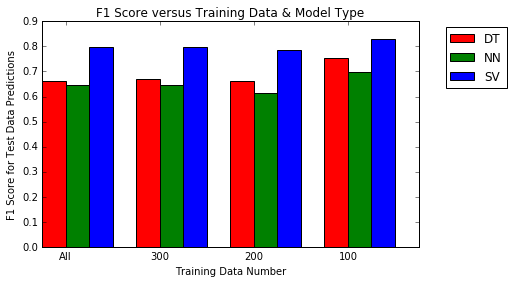

None


In [14]:
# Make bar plots of F1 scores versus training data numbers and classifier models.

ind = np.arange(4)
width = 0.25

for i in [0,1,2]:
    plt.bar(ind+i*width, (dfSE.at[i,'ScorTestyAll'],dfSE.at[i,'ScorTesty300'],dfSE.at[i,'ScorTesty200'],
                          dfSE.at[i,'ScorTesty100']), width=width, color=('r','g','b')[i], label=dfTM.at[i,'Cls'])

plt.xlabel("Training Data Number")
plt.ylabel("F1 Score for Test Data Predictions")
plt.title("F1 Score versus Training Data & Model Type")
plt.xticks(ind+width,('All','300','200','100'))
plt.legend(bbox_to_anchor=(1.25, 1))

plt.tight_layout()

print plt.show()

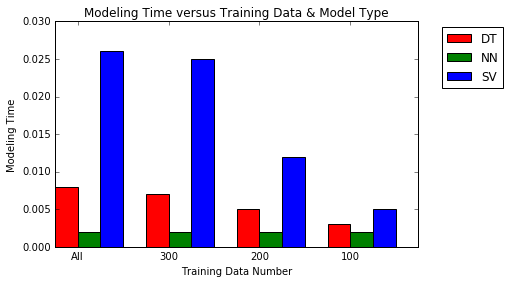

None


In [15]:
# Make bar plots of modeling times versus training data numbers and classifier models.

ind = np.arange(4)
width = 0.25

for i in [0,1,2]:
    plt.bar(ind+i*width, (dfTM.at[i,'TimeModelAll'],dfTM.at[i,'TimeModel300'],dfTM.at[i,'TimeModel200'],
                          dfTM.at[i,'TimeModel100']), width=width, color=('r','g','b')[i], label=dfTM.at[i,'Cls'])

plt.xlabel("Training Data Number")
plt.ylabel("Modeling Time")
plt.title("Modeling Time versus Training Data & Model Type")
plt.xticks(ind+width,('All','300','200','100'))
plt.legend(bbox_to_anchor=(1.25, 1))

plt.tight_layout()

print plt.show()

In [16]:
# Show classifier with the best total F1 score for test data predictions.

def varSE(i):
    return dfSE.iat[i,2]+dfSE.iat[i,3]+dfSE.iat[i,4]+dfSE.iat[i,5], i, dfSE.iat[i,0], dfSE.iat[i,1]

maxSE = max([varSE(0), varSE(1), varSE(2)])

print "Classifier with the best total F1 score for test data predictions:"
print maxSE[2] + " - " + maxSE[3] + "\n"
print dfCL.iat[maxSE[1],2]

# Show classifier with the best individual-run F1 score for test data predictions.

def warSE(i,j):
    return dfSE.iat[i,j+2], i, dfSE.iat[i,0], dfSE.iat[i,1], j, ["AllData","300Data","200Data","100Data"][j]

zmaxSE = max([warSE(0,0),warSE(0,1),warSE(0,2),warSE(0,3),
              warSE(1,0),warSE(1,1),warSE(1,2),warSE(1,3),
              warSE(2,0),warSE(2,1),warSE(2,2),warSE(2,3)])

print "\nClassifier with the best individual-run F1 score for test data predictions:"
print zmaxSE[2] + " - " + zmaxSE[3] + " - " + zmaxSE[5] + "\n"
print dfCL.iat[zmaxSE[1],2]

Classifier with the best total F1 score for test data predictions:
SV - Support Vector

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Classifier with the best individual-run F1 score for test data predictions:
SV - Support Vector - 100Data

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [17]:
# Define functions for fine tuning a model.

def performance_metric(label, prediction):
    return f1_score(label, prediction, pos_label='yes')

def draw_graph(train_f1s, test_f1s, variab, tit, xla):
    pl.figure()
    pl.plot(variab, train_f1s, lw=2, label = 'Training F1 Score')
    pl.plot(variab, test_f1s, lw=2, label = 'Test F1 Score')
    pl.title(tit)
    pl.xlabel(xla)
    pl.ylabel('F1 Score')
    pl.legend(bbox_to_anchor=(1.5, 1))
    pl.show()

def learning_curve(classif, tit, X_train, y_train, X_test, y_test):
    sizes = np.int_(np.round(np.linspace(10, len(X_train), 50)))
    train_f1s = np.zeros(len(sizes))
    test_f1s = np.zeros(len(sizes))
    for i, s in enumerate(sizes):
        clf = classif
        clf.fit(X_train[:s], y_train[:s])
        train_f1s[i] = performance_metric(y_train[:s], clf.predict(X_train[:s]))
        test_f1s[i] = performance_metric(y_test, clf.predict(X_test))
    print tit
    print "Classifier"
    print clf
    print "Training F1 Score: Mean, Min, Max"
    print str(np.mean(train_f1s)) + ", " + str(np.min(train_f1s)) + ", " + str(np.max(train_f1s))
    print "Test F1 Score: Mean, Min, Max"
    print str(np.mean(test_f1s)) + ", " + str(np.min(test_f1s)) + ", " + str(np.max(test_f1s))
    print draw_graph(train_f1s, test_f1s, sizes, tit, "Training Size")
    print  "=" * 100

def model_complexity(clastype, param, tit, xla, X_train, y_train, X_test, y_test):
    train_f1s = np.zeros(len(param))
    test_f1s = np.zeros(len(param))
    for i, d in enumerate(param):
        # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx Below needs improvemnt. xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
        if clastype == "SV":
            clf = svm.SVC(max_iter=d)
        else:
            if clastype == "DT":
                clf = tree.DecisionTreeClassifier(max_depth=d)
        # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx Above needs improvemnt. xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
        clf.fit(X_train, y_train)
        train_f1s[i] = performance_metric(y_train, clf.predict(X_train))
        test_f1s[i] = performance_metric(y_test, clf.predict(X_test))
    print tit
    print draw_graph(train_f1s, test_f1s, param, tit, xla)
    print "=" * 100

def fit_predict_model(classif, param, tit, X, y):
    perform = metrics.make_scorer(performance_metric, greater_is_better=True)
    reg = grid_search.GridSearchCV(classif, param, scoring=perform, refit=True, cv=None, verbose=0)
    print tit
    print "Model Fitting"
    print reg.fit(X, y)
    print "Best Parameter"
    print reg.best_params_
    print "Best F1 Score"
    print reg.best_score_

Support Vector Learning Curve (F1 Score vs Training Size) for Max Iterations 1
Classifier
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training F1 Score: Mean, Min, Max
0.570223677749, 0.093023255814, 0.888888888889
Test F1 Score: Mean, Min, Max
0.548226752878, 0.0588235294118, 0.791946308725


C:\Programs\Python27Anaconda\lib\site-packages\sklearn\svm\base.py:224: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


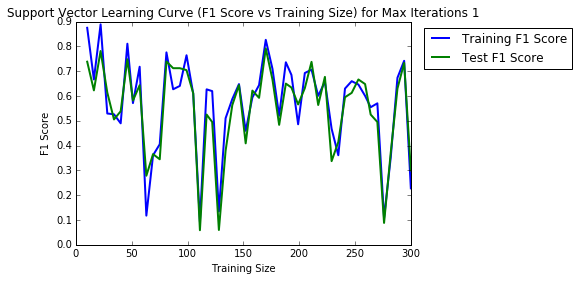

None
Support Vector Learning Curve (F1 Score vs Training Size) for Max Iterations 10
Classifier
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=10, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training F1 Score: Mean, Min, Max
0.782975351063, 0.473895582329, 0.941176470588
Test F1 Score: Mean, Min, Max
0.704346422459, 0.4, 0.816901408451


C:\Programs\Python27Anaconda\lib\site-packages\sklearn\svm\base.py:224: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


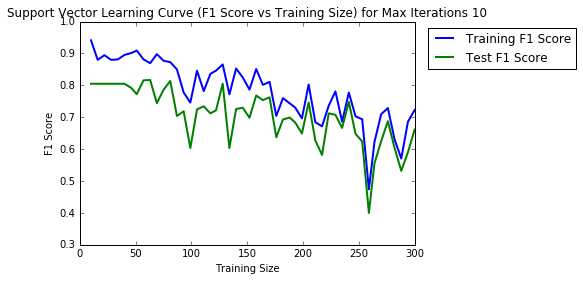

None
Support Vector Learning Curve (F1 Score vs Training Size) for Max Iterations 100
Classifier
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training F1 Score: Mean, Min, Max
0.884981046937, 0.86, 0.941176470588
Test F1 Score: Mean, Min, Max
0.814613574882, 0.786666666667, 0.834437086093


C:\Programs\Python27Anaconda\lib\site-packages\sklearn\svm\base.py:224: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


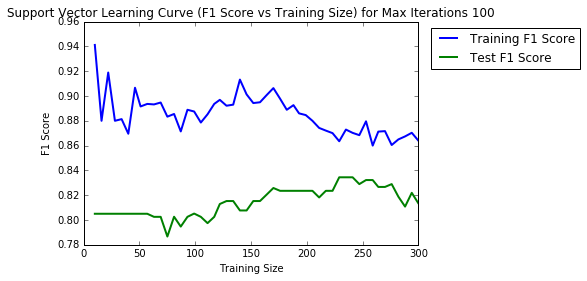

None
Support Vector Learning Curve (F1 Score vs Training Size) for Max Iterations 1000
Classifier
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training F1 Score: Mean, Min, Max
0.884509237074, 0.861607142857, 0.941176470588
Test F1 Score: Mean, Min, Max
0.814905516488, 0.786666666667, 0.834437086093


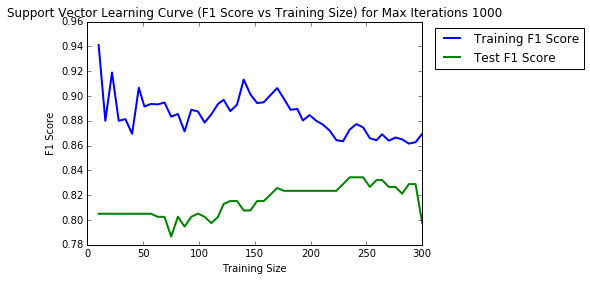

None
Support Vector Learning Curve (F1 Score vs Training Size) for Max Iterations -1
Classifier
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Training F1 Score: Mean, Min, Max
0.884509237074, 0.861607142857, 0.941176470588
Test F1 Score: Mean, Min, Max
0.814905516488, 0.786666666667, 0.834437086093


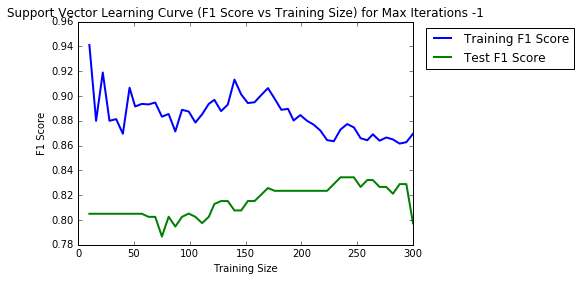

None
Support Vector Model Complexity (F1 Score vs Max Iterations)


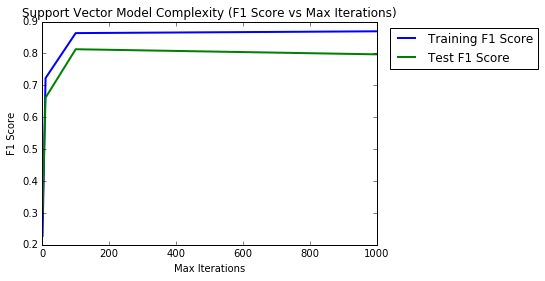

None
Support Vector Best Fit Model
Model Fitting
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_iter': (1, 10, 100, 1000, -1)},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(performance_metric), verbose=0)
Best Parameter
{'max_iter': 100}
Best F1 Score
0.799317178907


In [18]:
# Fine-tune Support Vector model.

for miter in [1, 10, 100, 1000, -1]:
    tit = "Support Vector Learning Curve (F1 Score vs Training Size) for Max Iterations " + str(miter)
    learning_curve(svm.SVC(max_iter=miter), tit, X_train, y_train, X_test, y_test)

tit = "Support Vector Model Complexity (F1 Score vs Max Iterations)"
model_complexity("SV", (1,10,100,1000), tit, "Max Iterations", X_train, y_train, X_test, y_test)

tit = "Support Vector Best Fit Model"
fit_predict_model(svm.SVC(), {'max_iter':(1,10,100,1000,-1)}, tit, X_all, y_all)

Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations 1
Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Training F1 Score: Mean, Min, Max
0.8457362831, 0.816326530612, 0.941176470588
Test F1 Score: Mean, Min, Max
0.789838512798, 0.715328467153, 0.802631578947


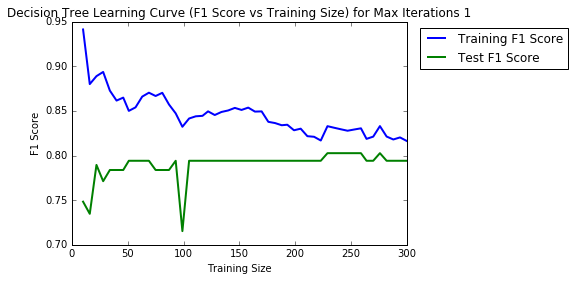

None
Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations 2
Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Training F1 Score: Mean, Min, Max
0.869180906341, 0.816326530612, 1.0
Test F1 Score: Mean, Min, Max
0.777546465722, 0.651851851852, 0.824324324324


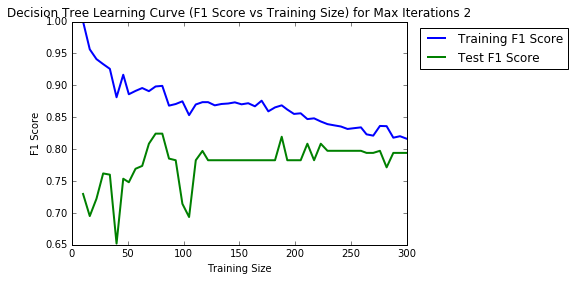

None
Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations 3
Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Training F1 Score: Mean, Min, Max
0.889290058092, 0.845528455285, 1.0
Test F1 Score: Mean, Min, Max
0.755816358339, 0.612903225806, 0.814285714286


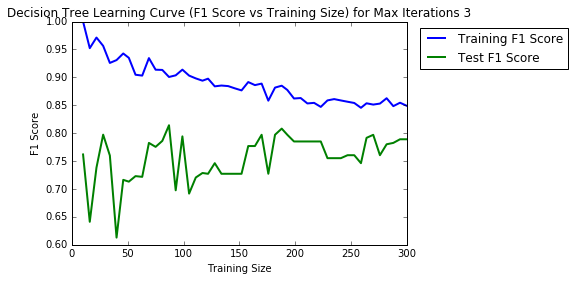

None
Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations 4
Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Training F1 Score: Mean, Min, Max
0.911345226724, 0.862068965517, 1.0
Test F1 Score: Mean, Min, Max
0.751743122607, 0.629032258065, 0.805555555556


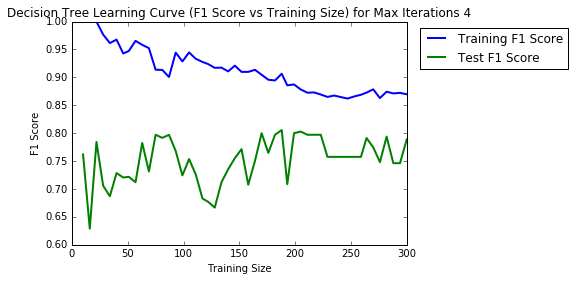

None
Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations 5
Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Training F1 Score: Mean, Min, Max
0.936733876679, 0.881927710843, 1.0
Test F1 Score: Mean, Min, Max
0.739325863098, 0.612903225806, 0.832116788321


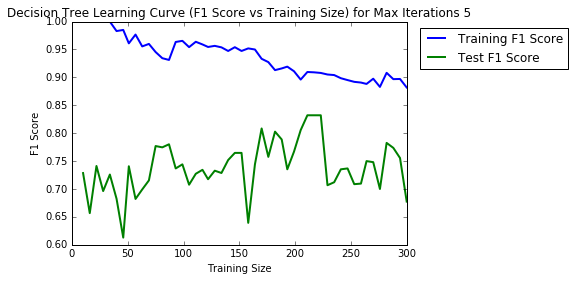

None
Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations 6
Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Training F1 Score: Mean, Min, Max
0.957005917189, 0.9, 1.0
Test F1 Score: Mean, Min, Max
0.73061992393, 0.596774193548, 0.811594202899


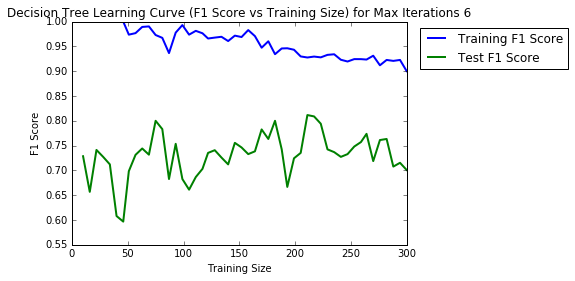

None
Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations 7
Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Training F1 Score: Mean, Min, Max
0.972878256191, 0.933660933661, 1.0
Test F1 Score: Mean, Min, Max
0.714549753263, 0.634920634921, 0.796992481203


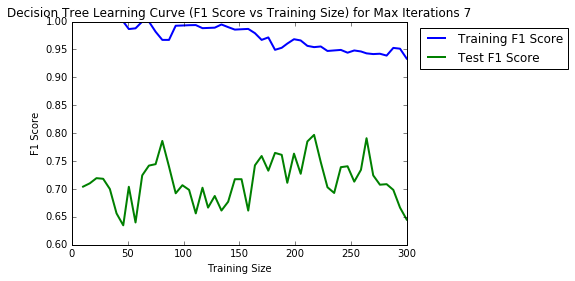

None
Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations 8
Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Training F1 Score: Mean, Min, Max
0.982689771912, 0.950391644909, 1.0
Test F1 Score: Mean, Min, Max
0.701306137841, 0.590163934426, 0.805970149254


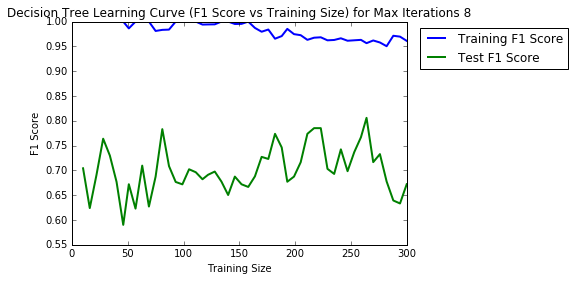

None
Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations 9
Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Training F1 Score: Mean, Min, Max
0.990734760546, 0.967032967033, 1.0
Test F1 Score: Mean, Min, Max
0.702356631403, 0.617886178862, 0.776978417266


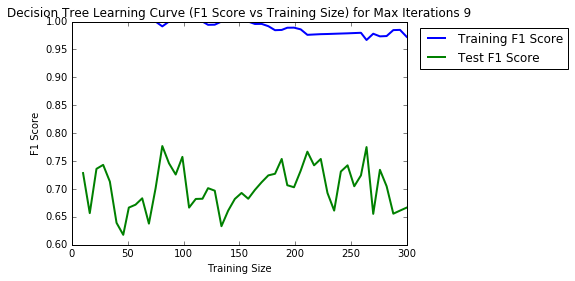

None
Decision Tree Model Complexity (F1 Score vs Max Depth)


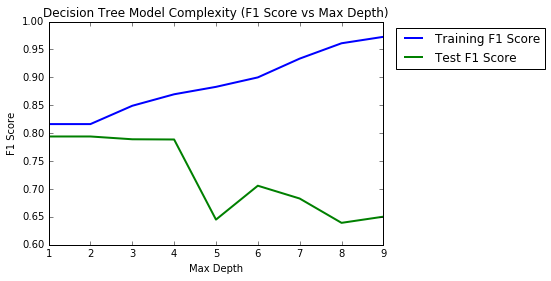

None
Decision Tree Best Fit Model
Model Fitting
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(performance_metric), verbose=0)
Best Parameter
{'max_depth': 1}
Best F1 Score
0.805354103754


In [19]:
# Fine-tune Decision Tree model and report the best F1 score.

rang = np.arange(1,10)
for miter in rang:
    tit = "Decision Tree Learning Curve (F1 Score vs Training Size) for Max Iterations " + str(miter)
    learning_curve(tree.DecisionTreeClassifier(max_depth=miter), tit, X_train, y_train, X_test, y_test)

tit = "Decision Tree Model Complexity (F1 Score vs Max Depth)"
model_complexity("DT", rang, tit, "Max Depth", X_train, y_train, X_test, y_test)

tit = "Decision Tree Best Fit Model"
fit_predict_model(tree.DecisionTreeClassifier(), {'max_depth': rang}, tit, X_all, y_all)